In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm import tqdm
import datetime
import proplot as plot
from netCDF4 import Dataset
from wrf import getvar

sys.path.insert(1, '/work/08350/tg876493/stampede2/python_codes/2020_TC_CRF/dev/freddy0218/tools/')
import derive_var
%matplotlib inline

plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

#### Read variables

In [2]:
origin_path = '/scratch/06040/tg853394/tc/output/redux/maria/'
#Function####################################################
def read_some_azimuth_fields(fileloc=None,fieldname=None):
    dict_name = {}
    for inx,obj in enumerate(fileloc):
        field_read = xr.open_dataset(obj)
        dict_name[fieldname[inx]] = field_read
    return dict_name

def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx.values
#############################################################
ctrlvar_dict = read_some_azimuth_fields(fileloc=[origin_path+'ctl/azim_T_0-144hr.nc',
                                                origin_path+'ctl/azim_W_0-144hr.nc'],fieldname=['T','w'])
ncrf36var_dict = read_some_azimuth_fields(fileloc=[origin_path+'ncrf_36h/azim_T_36-144hr.nc',
                                                  origin_path+'ncrf_36h/azim_W_36-144hr.nc'],fieldname=['T','w'])

In [3]:
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx.values

import json,pickle
def save_to_pickle(loc=None,var=None):
    with open(loc,"wb") as f:
        pickle.dump(var,f)
    return None
from scipy.ndimage import gaussian_filter

path = '/work2/08350/tg876493/stampede2/python_codes/tcg_radiation/output/'
file = [path+'ctrl_thetaall',path+'ncrf36_thetaall',path+'ncrf60_thetaall']

output = []
for i in range(len(file)):
    with open(file[i],'rb') as f:
        output.append(pickle.load(f))
theta_dict = {'CTRL_theta':output[0],'NCRF36_theta':output[1],'NCRF60_theta':output[2]}
#########################################################################################################
# To be consistent with azimuthal files
########################################################################################################
ctrl_thetaA = np.swapaxes(np.asarray(theta_dict['CTRL_theta']),0,1)
ncrf36_thetaA = np.swapaxes(np.asarray(theta_dict['NCRF36_theta']),0,1)
#########################################################################################################
# Radius cut offs
#########################################################################################################
r0,r200=(nearest_index(ctrlvar_dict['T']['T'].radius,0),nearest_index(ctrlvar_dict['T']['T'].radius,200))
r300,r500=(nearest_index(ctrlvar_dict['T']['T'].radius,300),nearest_index(ctrlvar_dict['T']['T'].radius,500))

### Calc. vertical advection

In [4]:
from metpy.calc import pressure_to_height_std
from metpy.units import units
from metpy.calc import potential_temperature
path_coor = '/scratch/06040/tg853394/tc/output/redux/maria/ctl/post/U.nc'
coor = xr.open_dataset(path_coor)

def calc_den(pres=None,temperature=None):
    den_out = []
    for i in tqdm(range(39)):
        temppres = pres[i,:,:]*100
        temp_T = temperature[:,i,:,:].data
        
        den = np.asarray([temppres/(287*temp_T[indexin,:,:]) for indexin in range(temp_T.shape[0])])
        den_out.append(den)
    return np.swapaxes(np.asarray(den_out),0,1)
####################################################################################################
# Calc. Density
####################################################################################################
pressure3d = np.tile(coor.pres.data[:, np.newaxis, np.newaxis], (39,360,433))
ctrl_den = calc_den(pres=pressure3d,temperature=ctrlvar_dict['T']['T'])
ncrf36_den = calc_den(pres=pressure3d,temperature=ncrf36var_dict['T']['T'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.64it/s]


In [23]:
va_t1 = ctrl_den*ctrlvar_dict['w'].to_array()[0]*np.swapaxes(np.asarray(theta_dict['CTRL_theta']),0,1)

In [35]:
def calc_vertadv(den=None,w=None,theta=None,heightaxis=None):
    va_t1 = ((den*w.to_array()[0]*theta)).data
    print(heightaxis)
    #HGT_array = np.tile(height[np.newaxis,:,np.newaxis,np.newaxis],(den.shape[0],39,360,433))
    va_t1g = np.gradient(va_t1,heightaxis*1000,axis=1)/np.asarray(den)
    return va_t1g

height = pressure_to_height_std(units.Quantity(coor.pres.data,'hPa'))
ctrl_thetavertadv = calc_vertadv(ctrl_den,ctrlvar_dict['w'],np.swapaxes(np.asarray(theta_dict['CTRL_theta']),0,1),height.magnitude)
ncrf36_thetavertadv = calc_vertadv(ncrf36_den,ncrf36var_dict['w'],np.swapaxes(np.asarray(theta_dict['NCRF36_theta']),0,1),height.magnitude)

[ 0.11082458  0.3232067   0.5400467   0.7615559   0.9879667   1.21953
  1.4565151   1.69921     1.9479368   2.2030387   2.4648964   2.733916
  3.0105577   3.2953174   3.5887527   3.8914685   4.2041564   4.5275793
  4.8625965   5.2101793   5.571434    5.9476233   6.3402047   6.750861
  7.1815677   7.634656    8.112902    8.619657    9.159027    9.736116
 10.357374   11.031161   11.768574   12.584839   13.501715   14.552005
 15.788846   17.307854   19.312405  ]
[ 0.11082458  0.3232067   0.5400467   0.7615559   0.9879667   1.21953
  1.4565151   1.69921     1.9479368   2.2030387   2.4648964   2.733916
  3.0105577   3.2953174   3.5887527   3.8914685   4.2041564   4.5275793
  4.8625965   5.2101793   5.571434    5.9476233   6.3402047   6.750861
  7.1815677   7.634656    8.112902    8.619657    9.159027    9.736116
 10.357374   11.031161   11.768574   12.584839   13.501715   14.552005
 15.788846   17.307854   19.312405  ]


#### Step 1: Smooth

In [36]:
ctrl_thetavertadv_s = derive_var.do_gauss_smooth(var=ctrl_thetavertadv,gaussian=[3,0,0])
ncrf36_thetavertadv_s = derive_var.do_gauss_smooth(var=ncrf36_thetavertadv,gaussian=[3,0,0])

Finished!
Finished!


#### Step 2: Patch to homogenize simulation outputs

In [37]:
def add_ctrl_before_senstart(CTRLvar=None,SENvar=None,exp='NCRF36',firstdo='Yes'):
    if firstdo=='Yes':
        if exp=='NCRF36':
            return np.concatenate((CTRLvar[0:36],SENvar))
        elif exp=='NCRF60':
            return np.concatenate((CTRLvar[0:60],SENvar))
    else:
        return SENvar
NCRF36_thetavertadv_sl = add_ctrl_before_senstart(ctrl_thetavertadv_s,ncrf36_thetavertadv_s,'NCRF36','Yes')

#### Step 3: Profile comparison

In [38]:
path = '/work2/08350/tg876493/stampede2/python_codes/2020_TC_CRF/dev/freddy0218/pca/output/gauss_smooth/'
file = [path+'ctl/residual',path+'ncrf36/residual']

output = []
for i in range(len(file)):
    with open(file[i],'rb') as f:
        output.append(pickle.load(f))
var_dict = {'CTRL_residual':output[0],'NCRF36_residual':output[1]}
#           'CTRL_swcheat':output[6],'NCRF36_swcheat':output[7]}
del output

Night/Day

In [39]:
import datetime,pytz
def divide_nightday(array=None,timedivider=None,startindex=23):
    night,day,alll = [],[],[]
    for i in range(len(timedivider[startindex:])):
        temp = array[startindex:,:,:,:r500]
        nightday = timedivider[startindex:]
        if nightday[i]==False:
            day.append(temp[i,:,:,:r500])
            alll.append(temp[i,:,:,:r500])
        else:
            night.append(temp[i,:,:,:r500])
            alll.append(temp[i,:,:,:r500])
    del i
    return np.asarray(day),np.asarray(night),np.asarray(alll)

start = datetime.datetime(2017,9,14,12,0,0)
start_residual = datetime.datetime(2017,9,14,13,0,0)
timeaxis,timeaxis_residual=[start+datetime.timedelta(hours = -4)],[start_residual+datetime.timedelta(hours = -4)] #UTC-4
for i in range(144):
    timeaxis.append(timeaxis[-1]+datetime.timedelta(hours=1))
    timeaxis_residual.append(timeaxis_residual[-1]+datetime.timedelta(hours=1))

timeaxis_night = [timeaxisobj.hour<6 or timeaxisobj.hour>18 for timeaxisobj in timeaxis]
timeaxis_night_residual = [timeaxisobj.hour<6 or timeaxisobj.hour>18 for timeaxisobj in timeaxis_residual]

In [40]:
############################################################################################
# Nighttime/Daytime Partition 170915/08-
############################################################################################
timeaxis_night = [timeaxisobj.hour<6 or timeaxisobj.hour>18 for timeaxisobj in timeaxis]
timeaxis_night_residual = [timeaxisobj.hour<6 or timeaxisobj.hour>18 for timeaxisobj in timeaxis_residual]
############################################################################################
# Divide variables
############################################################################################
# Vertical Advection
thetavertadv_s_d,thetavertadv_s_n,thetavertadv_s_all = divide_nightday(ctrl_thetavertadv_s,timeaxis_night,36)
ncrf36thetavertadv_s_d,ncrf36thetavertadv_s_n,ncrf36thetavertadv_s_all = divide_nightday(NCRF36_thetavertadv_sl,timeaxis_night,36)
# Residual
residual_d,residual_n,residual_all = divide_nightday(var_dict['CTRL_residual'],timeaxis_night_residual[:-1],35)
ncrf36residual_d,ncrf36residual_n,ncrf36residual_all = divide_nightday(var_dict['NCRF36_residual'],timeaxis_night_residual[:-1],35)

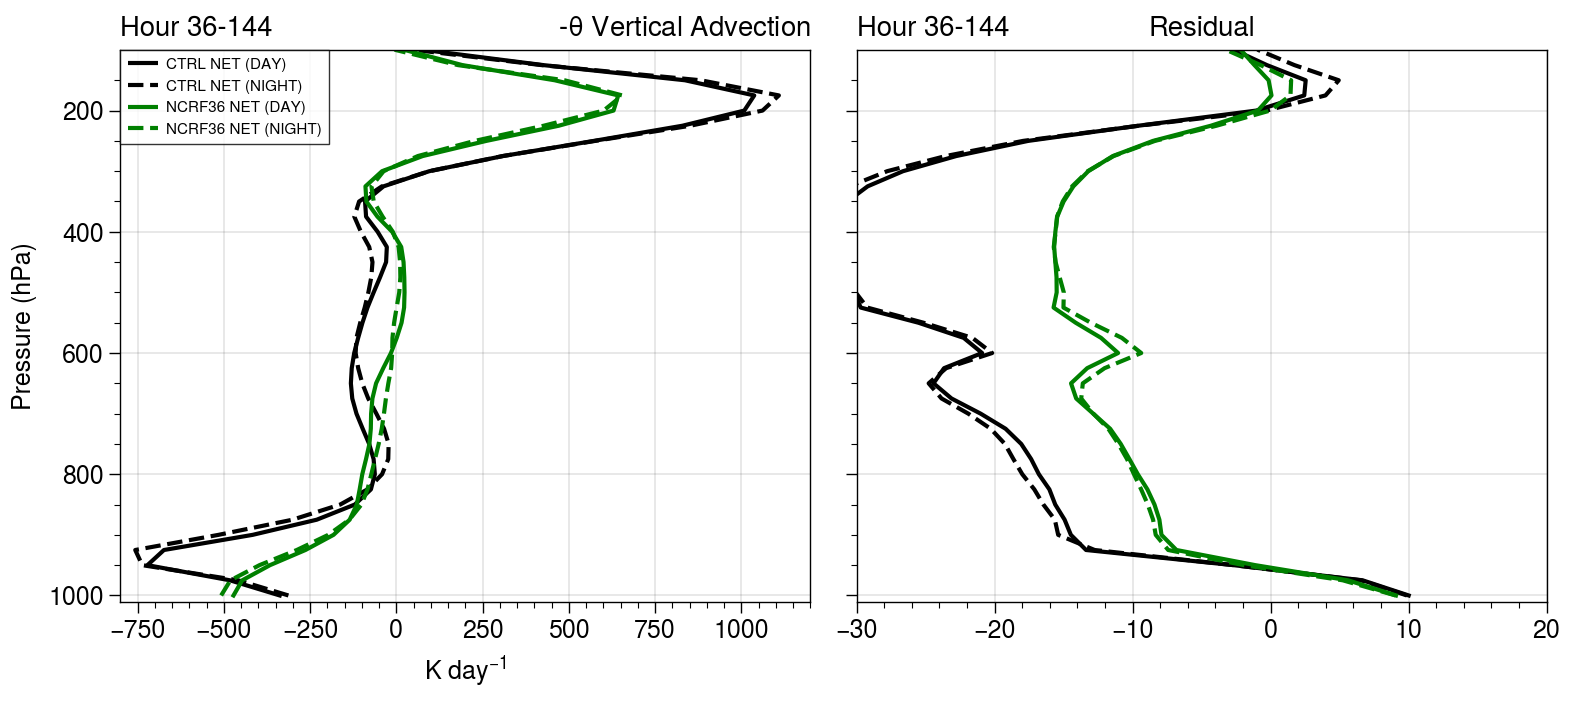

In [53]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=3.45,refaspect=1.251,span=False)
############################################################################################
# Net Heating + Radiative 
############################################################################################
axs[0].plot(-np.nanmean(thetavertadv_s_d,axis=(0,2,3))*3600*24,coor.pres,color='k',lw=1.5,
            label='CTRL NET (DAY)')
axs[0].plot(-np.nanmean(thetavertadv_s_n,axis=(0,2,3))*3600*24,coor.pres,color='k',lw=1.5,ls='--',
           label='CTRL NET (NIGHT)')
axs[0].plot(-np.nanmean(ncrf36thetavertadv_s_d,axis=(0,2,3))*3600*24,coor.pres,color='g',lw=1.5,
            label='NCRF36 NET (DAY)')
axs[0].plot(-np.nanmean(ncrf36thetavertadv_s_n,axis=(0,2,3))*3600*24,coor.pres,color='g',lw=1.5,ls='--',
            label='NCRF36 NET (NIGHT)')
axs[0].format(ylim=[1010,100],ltitle='Hour 36-144',xlabel=r'K day$^{-1}$',
              ylabel='Pressure (hPa)',rtitle=r'-$\theta$ Vertical Advection',xlim=[-800,1200])
axs[0].legend(loc='ul',ncols=1,prop=dict(size=5.5))

############################################################################################
# Net Heating + Radiative 
############################################################################################
axs[1].plot(np.nanmean(residual_d*3600*24,axis=(0,2,3)),coor.pres,color='k',lw=1.5,
            label='CTRL NET (DAY)')
axs[1].plot(np.nanmean(residual_n*3600*24,axis=(0,2,3)),coor.pres,color='k',lw=1.5,ls='--',
           label='CTRL NET (NIGHT)')
axs[1].plot(np.nanmean(ncrf36residual_d*3600*24,axis=(0,2,3)),coor.pres,color='g',lw=1.5,
            label='NCRF36 NET (DAY)')
axs[1].plot(np.nanmean(ncrf36residual_n*3600*24,axis=(0,2,3)),coor.pres,color='g',lw=1.5,ls='--',
            label='NCRF36 NET (NIGHT)')
axs[1].format(ylim=[1010,100],ltitle='Hour 36-144',#xlabel=r'K m day$^{-1}$',
              ylabel='Pressure (hPa)',title=r'Residual',xlim=[-30,20])
#axs[1].format(ylim=[1010,100],xlim=[-0.25*24,0.15*24],ltitle='Hour 36-144',rtitle='Net Heating: Average',xlabel=r'K day$^{-1}$',
#              ylabel='Pressure (hPa)')
#axs[1].legend(loc='ll',ncols=1,prop=dict(size=5.5))

plt.savefig('./proc_fig/negthetavertadv_ctrlncrf36.png',dpi=200)
plt.show()

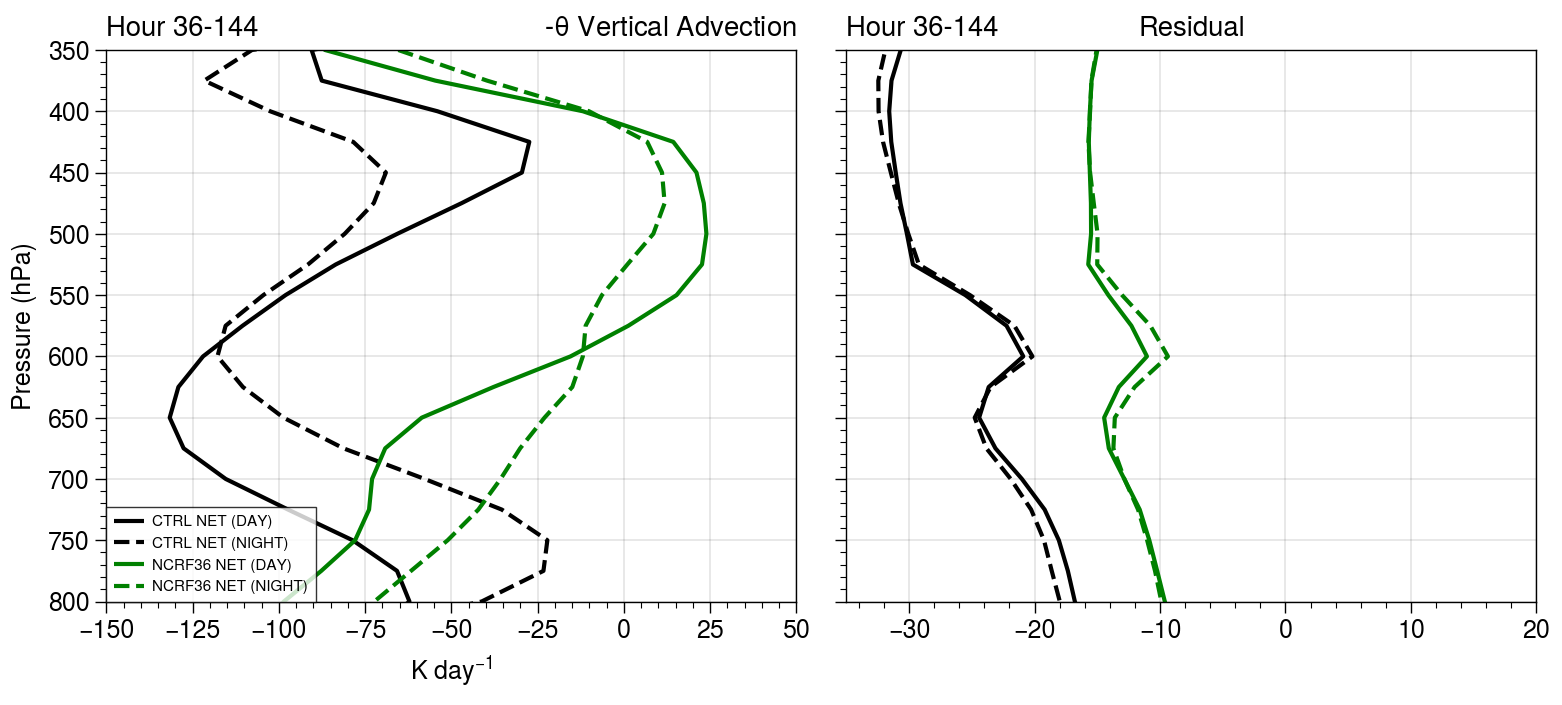

In [54]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=3.45,refaspect=1.251,span=False)
############################################################################################
# Net Heating + Radiative 
############################################################################################
axs[0].plot(-np.nanmean(thetavertadv_s_d,axis=(0,2,3))*3600*24,coor.pres,color='k',lw=1.5,
            label='CTRL NET (DAY)')
axs[0].plot(-np.nanmean(thetavertadv_s_n,axis=(0,2,3))*3600*24,coor.pres,color='k',lw=1.5,ls='--',
           label='CTRL NET (NIGHT)')
axs[0].plot(-np.nanmean(ncrf36thetavertadv_s_d,axis=(0,2,3))*3600*24,coor.pres,color='g',lw=1.5,
            label='NCRF36 NET (DAY)')
axs[0].plot(-np.nanmean(ncrf36thetavertadv_s_n,axis=(0,2,3))*3600*24,coor.pres,color='g',lw=1.5,ls='--',
            label='NCRF36 NET (NIGHT)')
axs[0].format(ylim=[800,350],ltitle='Hour 36-144',xlabel=r'K day$^{-1}$',
              ylabel='Pressure (hPa)',rtitle=r'-$\theta$ Vertical Advection',xlim=[-150,50])
axs[0].legend(loc='ll',ncols=1,prop=dict(size=5.5))

############################################################################################
# Net Heating + Radiative 
############################################################################################
axs[1].plot(np.nanmean(residual_d*3600*24,axis=(0,2,3)),coor.pres,color='k',lw=1.5,
            label='CTRL NET (DAY)')
axs[1].plot(np.nanmean(residual_n*3600*24,axis=(0,2,3)),coor.pres,color='k',lw=1.5,ls='--',
           label='CTRL NET (NIGHT)')
axs[1].plot(np.nanmean(ncrf36residual_d*3600*24,axis=(0,2,3)),coor.pres,color='g',lw=1.5,
            label='NCRF36 NET (DAY)')
axs[1].plot(np.nanmean(ncrf36residual_n*3600*24,axis=(0,2,3)),coor.pres,color='g',lw=1.5,ls='--',
            label='NCRF36 NET (NIGHT)')
axs[1].format(ylim=[800,350],ltitle='Hour 36-144',#xlabel=r'K m day$^{-1}$',
              ylabel='Pressure (hPa)',title=r'Residual',xlim=[-35,20])
#axs[1].format(ylim=[1010,100],xlim=[-0.25*24,0.15*24],ltitle='Hour 36-144',rtitle='Net Heating: Average',xlabel=r'K day$^{-1}$',
#              ylabel='Pressure (hPa)')
#axs[1].legend(loc='ll',ncols=1,prop=dict(size=5.5))

plt.savefig('./proc_fig/negthetavertadv_mid_ctrlncrf36.png',dpi=200)
plt.show()

In [7]:
path = '/work2/08350/tg876493/stampede2/python_codes/2020_TC_CRF/dev/freddy0218/pca/output/gauss_smooth/'
file = [path+'ctl/allradheat2',path+'ncrf36/allradheat2',\
       path+'ctl/thetagrad_b',path+'ncrf36/thetagrad_b']

output = []
for i in range(len(file)):
    with open(file[i],'rb') as f:
        output.append(pickle.load(f))
var_dict = {'CTRL_allradheat':output[0],'NCRF36_allradheat':output[1],
            'CTRL_thetagrad':output[2],'NCRF36_thetagrad':output[3]}

In [8]:
var_dict['CTRL_thetagrad'].all()==var_dict['NCRF36_thetagrad'].all()

True